In [23]:

import sys, os

# Get project root — one level up from 'research_and_analyst'
project_root = os.path.abspath(os.path.join(os.getcwd(), "../../"))
sys.path.append(project_root)

print("Project root added to path:", project_root)

Project root added to path: c:\Users\redhu\OneDrive\Desktop\deep_research_workflow\deep_research


In [25]:
#import model loader
from deep_research.backend_server.utils.model_loader import ModelLoader

loader = ModelLoader()
llm = loader.load_llm()
llm.invoke("hii")

{"timestamp": "2025-11-01T04:49:24.510654Z", "level": "info", "event": "OPENAI_API_KEY loaded from environment"}
{"timestamp": "2025-11-01T04:49:24.513246Z", "level": "info", "event": "GOOGLE_API_KEY loaded from environment"}
{"timestamp": "2025-11-01T04:49:24.515710Z", "level": "info", "event": "GROQ_API_KEY loaded from environment"}
{"timestamp": "2025-11-01T04:49:24.517650Z", "level": "warning", "event": "ASTRA_DB_API_ENDPOINT is missing from environment"}
{"timestamp": "2025-11-01T04:49:24.519691Z", "level": "warning", "event": "ASTRA_DB_APPLICATION_TOKEN is missing from environment"}
{"timestamp": "2025-11-01T04:49:24.522329Z", "level": "warning", "event": "ASTRA_DB_KEYSPACE is missing from environment"}
{"config_keys": ["astra_db", "embedding_model", "retriever", "llm"], "timestamp": "2025-11-01T04:49:24.530379Z", "level": "info", "event": "YAML config loaded"}
{"provider": "openai", "model": "gpt-4o", "timestamp": "2025-11-01T04:49:24.533019Z", "level": "info", "event": "Loading

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 9, 'total_tokens': 18, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'id': 'chatcmpl-CWxqNLy0IFErTGdfUMlv3NWPCiajG', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--50125a7b-05cf-4825-9768-24308908876d-0', usage_metadata={'input_tokens': 9, 'output_tokens': 9, 'total_tokens': 18, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [57]:
from typing import TypedDict, List
from pydantic import BaseModel,Field
from langgraph.graph import START,END,StateGraph
from langchain_core.messages import AIMessage,HumanMessage,SystemMessage
from langgraph.checkpoint.memory import MemorySaver

In [44]:

class Analyst(BaseModel):
    name: str = Field(description="name of analyst")
    role: str  = Field(description="role of analyst in the context of topic") 
    affiliation: str  = Field(description="primary affiliation of the analyst")
    description: str = Field(description="description of analyst, focus concern and motives")
    
    @property
    def persona(self) -> str:
        return (
            f"Name: {self.name}\n"
            f"Role: {self.role}\n"
            f"Affiliation: {self.affiliation}\n"
            f"Description: {self.description}\n"
        )
    

In [45]:
analyst = Analyst(
    name ='amit',
    role = "ML engineer",
    affiliation="AI research Lab",
    description="I am Ml engineer as well as Mechanical Engineer"
)

In [46]:
analyst.name

'amit'

In [47]:
analyst.role

'ML engineer'

In [49]:
print(analyst.persona)

Name: amit
Role: ML engineer
Affiliation: AI research Lab
Description: I am Ml engineer as well as Mechanical Engineer



In [66]:
class perspectives(BaseModel):
    analysts:List[Analyst] = Field(description="comprehensive list of analysts with their role and affiliations")
    
    

In [67]:
class GenerateAnalystState(TypedDict):
    topic: str
    max_analysts: int
    human_analyst_feedback: str
    analysts: List[Analyst]

In [68]:
analyst_instructions="""You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}
        
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
        
{human_analyst_feedback}
    
3. Determine the most interesting themes based upon documents and / or feedback above.
                    
4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""

In [100]:
def create_analyst(state:GenerateAnalystState):
    "create analyst"
    topic = state['topic']
    max_analysts = state['max_analysts']
    human_analyst_feedback = state.get("human_analyst_feedback","")
    
    llm_with_structured_output = llm.with_structured_output(perspectives)
    
    system_message = analyst_instructions.format(
        topic = topic,
        max_analysts = max_analysts,
        human_analyst_feedback = human_analyst_feedback
    )
    analysts = llm_with_structured_output.invoke([SystemMessage(content=system_message)] + [HumanMessage(content="generate a set of analysts")])
    
    return {"analysts":analysts.analysts}

    
                         

In [101]:
create_analyst(
    {'topic': 'health',
    'max_analysts': 2,
    'human_analyst_feedback': 'give the real info'}
    )

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'analysts': [Analyst(name='Dr. Emily Chen', role='Public Health Researcher', affiliation='World Health Organization', description='Dr. Emily Chen is a public health researcher with a focus on global health initiatives and disease prevention strategies. Her primary concern is understanding how health policies can be optimized to improve public health outcomes worldwide. She is motivated by the need to address health disparities and ensure equitable access to healthcare services.'),
  Analyst(name='Dr. Raj Patel', role='Healthcare Technology Specialist', affiliation='Harvard Medical School', description='Dr. Raj Patel specializes in the integration of technology in healthcare systems. His focus is on how digital health tools, such as telemedicine and health informatics, can enhance patient care and streamline healthcare delivery. He is driven by the potential of technology to transform healthcare accessibility and efficiency, particularly in underserved regions.')]}

In [102]:
def human_feedback(state):
    """ No-op node that should be interrupted on """
    pass

In [103]:
def should_continue(state):
    feedback = (state.get("human_analyst_feedback") or "").strip().lower()
    if feedback and feedback not in ["", "none", "skip", "done", "continue"]:
        return "create_analyst"
    return END

In [104]:
from IPython.display import Image, display

In [105]:
builder =  StateGraph(GenerateAnalystState)

In [106]:
# add nodes
builder.add_node("create_analyst", create_analyst)
builder.add_node("human_feedback", human_feedback)

# add edges
builder.add_edge(START, "create_analyst")
builder.add_edge("create_analyst", "human_feedback")

builder.add_conditional_edges(
    "human_feedback",
    should_continue,
    ["create_analyst", END]
)
                 

In [107]:
memory_saver = MemorySaver()

In [108]:
graph = builder.compile(interrupt_before=['human_feedback'],checkpointer=memory_saver)

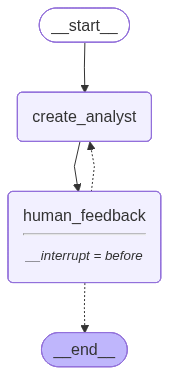

In [109]:
#display graph
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [110]:
topic = "the benefits of adopting Langgraph as an agent framework" 
max_analysts = 4
thread =  {"configurable":{"thread_id":1}}

In [111]:
for event in graph.stream({"topic":topic,
              "max_analysts":max_analysts},
             thread,
             stream_mode= "values"):
    analysts = event.get('analysts', '')
    
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50) 

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Name: Dr. Emily Chen
Affiliation: Institute for Emerging Technologies
Role: Technology Adoption Specialist
Description: Dr. Chen focuses on the strategic benefits of adopting new technologies in organizational settings. Her primary concern is how Langgraph can streamline processes and improve efficiency in agent-based systems. She is motivated by the potential for Langgraph to reduce operational costs and enhance decision-making capabilities.
--------------------------------------------------
Name: Raj Patel
Affiliation: Open Source Software Foundation
Role: Software Architect
Description: Raj is an advocate for open-source frameworks and their role in fostering innovation. He is particularly interested in Langgraph's modular architecture and its ability to integrate with existing systems. His focus is on the flexibility and scalability that Langgraph offers to developers and organizations.
--------------------------------------------------
Name: Sofia Martinez
Affiliation: Global AI E